# Implementing SK-ROCK algorithm - Application to CS-MRI

In this notebook I implement the recently-developed algorithm by Luis Vargas, Marcelo Pereyra and Konstantinos Zygakalis found in [this paper](https://arxiv.org/pdf/1908.08845.pdf).

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fftshift, ifftshift
from skimage import data, img_as_float
import helper as t

import time
from tqdm import tqdm_notebook

import pysap;
from pysap.data import get_sample_data;
from mri.numerics.fourier import NFFT
from mri.numerics.reconstruct import sparse_rec_fista
from mri.numerics.reconstruct import sparse_rec_condatvu
from mri.numerics.utils import generate_operators
from mri.numerics.utils import convert_mask_to_locations
from mri.reconstruct.linear import WaveletN, WaveletUD2
from modopt.math.metrics import ssim
from mri.numerics.fourier import FFT2
from mri.numerics.reconstruct import sparse_rec_fista
from mri.numerics.utils import generate_operators
from mri.numerics.utils import convert_mask_to_locations
from pysap.data import get_sample_data
from sklearn.metrics import mean_squared_error


# Third party import
import numpy as np
import scipy.fftpack as pfft


                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

matplotlib     : >=3.0.0   - required | 3.0.3     installed
astropy        : >=3.0.0   - required | 3.2.3     installed
scipy          : >=1.3.0   - required | 1.3.1     installed
nibabel        : >=2.3.2   - required | 2.5.1     installed
modopt         : >=1.4.0   - required | 1.4.0     installed
scikit-learn   : >=0.19.1  - required | ?         installed
progressbar2   : >=3.34.3  - required | ?         installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
pywt           : >=1.0.0   - requi

The image we will be working with for the purposes of this project is the [Shepp Logan phantom](https://en.wikipedia.org/wiki/Shepp%E2%80%93Logan_phantom), and so we load it in the next cell.

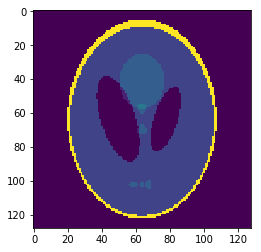

In [2]:
# fig =plt.figure(figsize=(10,8))
image = np.load('phantom.npy')
# plt.imshow(phantom)
# plt.show()

# Loading input data
# image = get_sample_data('2d-mri')
# Obtain K-Space Cartesian Mask
#mask = get_sample_data("cartesian-mri-mask")
plt.imshow(image)
#type(image[0,0])

We will use a radial mask for the purposes of this experiment.

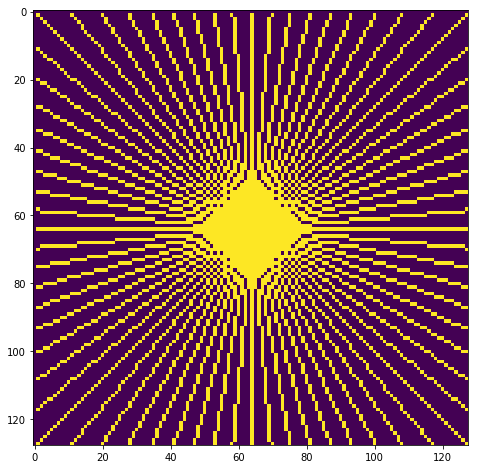

In [3]:
mask_temp = t.LineMask(number_of_angles=36, dim=128)
mask = fftshift(mask_temp)
fig =plt.figure(figsize=(10,8))
plt.imshow(mask)
plt.show()

In [4]:
kspace_loc = convert_mask_to_locations(np.fft.fftshift(mask.data))
fourier_op = FFT2(samples=kspace_loc, shape=image.shape)
kspace_data = fourier_op.op(image)

/volatile/home/bemsi/bemsi-python/lib/python3.5/site-packages/mri/reconstruct/utils.py:74: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1


## SK-ROCK Algorithm

The following function generates a given number of samples, given original data, according to the SK-ROCK algorithm

In [5]:
def sk_rock(observations, num_samples, sigma=1e-3/np.sqrt(2), num_stages=10, eta=0.05 ):
    """
    Generates samples from high-dimensional distributions, according to SK-ROCK 
    algorithm proposed by Luis Vargas et al (2019).
    
    INPUTS:
     - original_guess: initialisation of algorithm
     - image: number of samples to generate
     - sigma, eta: hyperparameters of prior
     - num_stages: number of internal Runge-Kutta stages
    
    OUTPUTS:
     - logPiTraces: array containing the values of logPi
     - data[-1]: the reconstructed image
     
    """
    alpha = 5e-4/sigma**2 # hyperparameter of prior
    lam = 0.2 *sigma**2  #approximation parameter of the MY envelop
    lipschitz_log_likelihood = 1/sigma**2 #Lipschitz constant of the log-likelihood 
    original_guess = fourier_op.adj_op(observations)
    
    
    ## Gradients - proximal gradients and other functions
    def gradF(x):
        return (fourier_op.adj_op(fourier_op.op(x) - observations))/sigma**2
        
    
    def proxG(x, param=alpha*lam):
        return t.chambolle_prox_TV(x, param, 25)
    
    def gradG(x):
        return (x - proxG(x))/lam
    
    def gradU(x):
        return gradF(x) + gradG(x)
    
    def logPi(x):
        return -(np.linalg.norm(observations - fourier_op.op(x))**2)/(2*sigma**2) - alpha*t.TVnorm(x)
    
       
    l = (num_stages - 0.5)**2 * (2 - (4/3)*eta) - 1.5
    step_size = 0.8*l/(lipschitz_log_likelihood + 1/lam)
        
    omega_0 = 1 + eta/num_stages**2
    omega_1 = t.chebyshev(num_stages, omega_0)/t.chebyshev_prime(num_stages, omega_0)
    mu_1 = omega_1/omega_0
    nu_1 = num_stages*omega_1/2
    kappa_1 = num_stages*omega_1/omega_0
    dimension = original_guess.shape[0]
    
    
    K = np.ndarray((num_stages, dimension, dimension), dtype=np.complex64)
    data = np.ndarray((num_samples, dimension, dimension), dtype=np.complex64)
    logPiTraces = np.zeros(num_samples)
    data[0] = original_guess
    logPiTraces[0] = logPi(data[0])
    
    for i in tqdm_notebook(range(num_samples-1)):
        Z = np.random.randn(dimension, dimension)
        K[0] = data[i]
        K[1] = K[0] - mu_1*step_size*gradU(K[0] + 
                    nu_1*np.sqrt(2*step_size)*Z) + kappa_1*np.sqrt(2*step_size)*Z
        
        for j in range(2,num_stages):
            mu = 2*omega_1*t.chebyshev(j-1, omega_0)/t.chebyshev(j, omega_0)
            nu = 2*omega_0*t.chebyshev(j-1, omega_0)/t.chebyshev(j, omega_0)
            kappa = 1 - nu
            
            K[j] = -mu *step_size*gradU(K[j-1])+ nu*K[j-1]+ kappa*K[j-2]
        data[i+1] = K[num_stages-1]
        logPiTraces[i+1] = logPi(data[i+1])
    return logPiTraces, abs(data[-1])

/volatile/home/bemsi/bemsi-python/lib/python3.5/site-packages/ipykernel_launcher.py:56: ComplexWarning: Casting complex values to real discards the imaginary part


/volatile/home/bemsi/bemsi-python/lib/python3.5/site-packages/ipykernel_launcher.py:71: ComplexWarning: Casting complex values to real discards the imaginary part


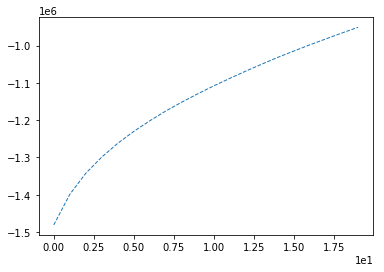

In [6]:
num_samples = 20 #Generation of samples
logPiTraces, images = sk_rock(kspace_data, num_samples)
plt.plot(range(num_samples),logPiTraces, linewidth=1, ls='--')
plt.ticklabel_format(axis='both', style='sci', scilimits=(-24, -7))
plt.show()

## FISTA Reconstruction

In [7]:
# Generate operators
gradient_op, linear_op, prox_op, cost_op = generate_operators(
    data=kspace_data,
    wavelet_name="sym8",
    samples=kspace_loc,
    nb_scales=3,
    mu=2e-7,
    uniform_data_shape=None,
    gradient_space="synthesis",
    padding_mode="periodization")

# Start the FISTA reconstruction
max_iter = 500
x_final, costs, metrics = sparse_rec_fista(
    gradient_op,
    linear_op,
    prox_op,
    cost_op,
    lambda_init=1,
    max_nb_of_iter=max_iter,
    atol=1e-4,
    verbose=1)
image_rec = pysap.Image(data=np.abs(x_final))
# image_rec.show()
# Calculate SSIM
recon_ssim = ssim(image_rec, image)
print('The Reconstruction SSIM is : ' + str(recon_ssim))

  1% (7 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:07


  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  2e-07
 - lipschitz constant:  1.1000000000004153
 - data:  (128, 128)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fe9db6f0588> - 3
 - max iterations:  500
 - image variable shape:  (128, 128)
 - alpha variable shape:  (16384,)
----------------------------------------
Starting optimization...


100% (500 of 500) |######################| Elapsed Time: 0:00:18 Time:  0:00:18


 - final iteration number:  500
 - final log10 cost value:  -3.6591619882678024
 - converged:  False
Done.
Execution time:  575.361867  seconds
----------------------------------------
The Reconstruction SSIM is : 0.42767580627061436


## Comparison of reconstructed images

We now compare the reconstructed images from SK-ROCK and FISTA. In particular, we will be using their Mean-Squared-Error

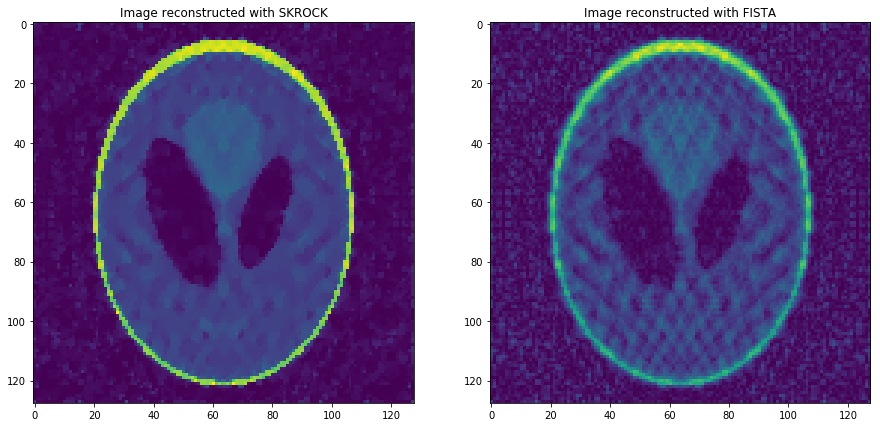

In [8]:
fig, ax = plt.subplots(1,2, figsize=(15,10))
ax[0].imshow(images)
ax[0].set_title('Image reconstructed with SKROCK')
ax[1].imshow(image_rec)
ax[1].set_title('Image reconstructed with FISTA')
plt.show()

In [9]:
error_skrock = mean_squared_error(images, image)
error_fista = mean_squared_error(image_rec, image)
improvement = (error_fista - error_skrock)/error_fista * 100
print(improvement)

80.08110173943552


At this stage we want to replace the linear operator. Instead of using the Total Variation norm, we want to use a wavelet transform of the image to see how well the algorithm will perform

In [10]:
# wavelet_operator = WaveletN(wavelet_name="sym8", nb_scale=4)
# image = wavelet_operator.op(phantom)

In [11]:
def sk_rock_wavelet(observations, num_samples, sigma=1e-3/np.sqrt(2), num_stages=10, eta=0.05 ):
    """
    Generates samples from high-dimensional distributions, according to SK-ROCK 
    algorithm proposed by Luis Vargas et al (2019).
    
    INPUTS:
     - original_guess: initialisation of algorithm
     - image: number of samples to generate
     - sigma, eta: hyperparameters of prior
     - num_stages: number of internal Runge-Kutta stages
    
    OUTPUTS:
     - logPiTraces: array containing the values of logPi
     - data[-1]: the reconstructed image
     
    """
    alpha = 5e-4/sigma**2 # hyperparameter of prior
    lam = 0.2 *sigma**2  #approximation parameter of the MY envelop
    lipschitz_log_likelihood = 1/sigma**2 #Lipschitz constant of the log-likelihood 
    original_guess = fourier_op.adj_op(observations)
    
    
    ## Gradients - proximal gradients and other functions
    def gradF(x):
        return (fourier_op.adj_op(fourier_op.op(x) - observations))/sigma**2
        
    
    def proxG(x, param=alpha*lam):
        return t.chambolle_prox_TV(x, param, 25)
    
    def gradG(x):
        return x + wavelet_operator.adj_op(proxG(wavelet_operator.op(x)) - wavelet_operator.op(x))/lam
    
    def gradU(x):
        return gradF(x) + gradG(x)
    
    def logPi(x):
        return -(np.linalg.norm(observations - fourier_op.op(x))**2)/(2*sigma**2) - alpha*t.np.sum(wavelet_operator.op(x))
    
       
    l = (num_stages - 0.5)**2 * (2 - (4/3)*eta) - 1.5
    step_size = 0.8*l/(lipschitz_log_likelihood + 1/lam)
        
    omega_0 = 1 + eta/num_stages**2
    omega_1 = t.chebyshev(num_stages, omega_0)/t.chebyshev_prime(num_stages, omega_0)
    mu_1 = omega_1/omega_0
    nu_1 = num_stages*omega_1/2
    kappa_1 = num_stages*omega_1/omega_0
    dimension = original_guess.shape[0]
    
    
    K = np.ndarray((num_stages, dimension, dimension), dtype=np.complex64)
    data = np.ndarray((num_samples, dimension, dimension), dtype=np.complex64)
    logPiTraces = np.zeros(num_samples)
    data[0] = original_guess
    logPiTraces[0] = logPi(data[0])
    
    for i in tqdm_notebook(range(num_samples-1)):
        Z = np.random.randn(dimension, dimension)
        K[0] = data[i]
        K[1] = K[0] - mu_1*step_size*gradU(K[0] + 
                    nu_1*np.sqrt(2*step_size)*Z) + kappa_1*np.sqrt(2*step_size)*Z
        
        for j in range(2,num_stages):
            mu = 2*omega_1*t.chebyshev(j-1, omega_0)/t.chebyshev(j, omega_0)
            nu = 2*omega_0*t.chebyshev(j-1, omega_0)/t.chebyshev(j, omega_0)
            kappa = 1 - nu
            
            K[j] = -mu *step_size*gradU(K[j-1])+ nu*K[j-1]+ kappa*K[j-2]
        data[i+1] = K[num_stages-1]
        logPiTraces[i+1] = logPi(data[i+1])
    return logPiTraces, abs(data[-1])

In [12]:
# num_samples = 10 #Generation of samples
# logPiTraces, images = sk_rock_wavelet(kspace_data, num_samples)
# plt.plot(range(num_samples),logPiTraces, linewidth=1, ls='--')
# plt.ticklabel_format(axis='both', style='sci', scilimits=(-24, -7))
# plt.show()